# 0. Imports

In [105]:
import polars as pl

from matplotlib import pyplot as plt
from matplotlib import ticker, dates

import seaborn as sns

In [2]:
pl.Config.set_fmt_float("full")
sns.set_style('darkgrid')

# 1. Importação dos dados
Importação e primeiros tratamentos dos dados

In [3]:
#importanto e fazendo tratamentos iniciais
df = (pl.read_csv(
    '../m1-analise-exploratoria/data/AIH_processamento.csv', 
    separator=';', 
    truncate_ragged_lines=True, 
    encoding='ISO-8859-1', 
    skip_rows=3, 
    null_values=['-'], 
    row_count_name='index')
.filter(
    pl.col('index') <= 26
)
.select(
    pl.col("index"),
    pl.col("Unidade da Federação").str.replace(r"[0-9]+ ", "").alias("uf"),
    pl.col("*")
        .exclude("index", "Unidade da Federação", "Total")
        .str.replace(",", ".")
        .cast(pl.Float64)
))

In [4]:
def map_region(estado):
    return ('Sudeste' if estado in ['São Paulo', 'Minas Gerais', 'Rio de Janeiro', 'Espírito Santo'] else
            'Sul' if estado in ['Paraná', 'Rio Grande do Sul', 'Santa Catarina'] else 
            'Centro-Oeste' if estado in ['Goiás', 'Distrito Federal', 'Mato Grosso do Sul', 'Mato Grosso'] else 
            'Norte' if estado in ['Rondônia', 'Acre', 'Amazonas', 'Roraima', 'Pará', 'Amapá', 'Tocantins'] else 
            'Nordeste')

# Aplicar o mapeamento e criar uma nova coluna 'Regiao'
df = df.with_columns(
    pl.col('uf').map_elements(map_region).alias('regiao')
)

In [5]:
df.head()

index,uf,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,2008/Nov,2008/Dez,2009/Jan,2009/Fev,2009/Mar,2009/Abr,2009/Mai,2009/Jun,2009/Jul,2009/Ago,2009/Set,2009/Out,2009/Nov,2009/Dez,2010/Jan,2010/Fev,2010/Mar,2010/Abr,2010/Mai,2010/Jun,2010/Jul,2010/Ago,2010/Set,2010/Out,2010/Nov,…,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,2021/Abr,2021/Mai,2021/Jun,2021/Jul,2021/Ago,2021/Set,2021/Out,2021/Nov,2021/Dez,2022/Jan,2022/Fev,2022/Mar,2022/Abr,2022/Mai,2022/Jun,2022/Jul,2022/Ago,2022/Set,2022/Out,2022/Nov,2022/Dez,2023/Jan,2023/Fev,2023/Mar,2023/Abr,2023/Mai,2023/Jun,regiao
u32,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
0,"""Rondônia""",1388528.39,2931283.42,1541682.52,1525314.96,1645953.84,1406150.68,3065279.01,3231494.61,3117178.63,3068430.44,2825838.52,2931173.58,2885269.07,2860103.74,3684944.68,3607289.68,3774356.6,3706711.84,3763187.55,3533625.83,3605007.43,3907032.72,3939820.71,3901084.11,3684407.02,3623015.58,3890461.9,4193533.87,4534400.67,4451208.03,4874592.78,4460802.38,5067886.24,4511092.85,4394680.5,…,11954489.94,11887993.85,10328280.19,8068024.57,9486450.48,9020062.64,9861592.32,9812340.48,14953391.13,15563729.11,16492196.14,15572901.51,14742747.37,13054732.77,12115394.39,9768041.54,11098424.77,11210055.47,11094746.21,12431841.65,12174377.23,11121899.06,10347874.99,8671261.99,9864471.65,9145590.72,10292958.39,9160542.91,9324183.87,11135187.34,10253476.82,8564028.28,11145654.32,10349162.16,13496368.3,10016527.33,"""Norte"""
1,"""Acre""",902416,1497206.26,1794028.48,1730469.42,1819443.92,1828496,2511754.59,2089107.14,2275708.53,1923886.57,1756986.8,2235639.98,2497116.43,2253558.01,2122673.92,2834317.62,2722065.97,2432831.95,2630190.65,2307579,null,2826477.02,2170791.18,2541526.44,2491042.33,1954473.9,2389996.38,2654878.6,2844085.21,2336207.19,2125143.06,2430293.67,2377738.44,2184746.84,2468452.9,…,3915193.2,3640142.82,3391242.21,4044321.44,3276590.1,3696997.31,3715723.12,3538427.92,4077045.92,6307616.67,6354514.15,3461663.11,4979239.3,4138751.64,4260017.06,3828566.34,2889654.47,3138245.58,3547361.84,3424337.76,3584824.97,3791898.2,4523687.48,2978062.37,2802612.38,3793316.97,3310293.3,3511587.05,4110985.51,3999023.9,3492410.89,4261938.15,4927482.49,4701182.54,4845006.75,5124899,"""Norte"""
2,"""Amazonas""",4735529.42,7118990.57,8196635.49,8259378.42,7831399.9,8477273.62,9368858.72,9352532.7,9363099.35,8618318.83,6555549.08,7777645.88,7403068.36,6683346.89,9927781.2,8844511.21,9079035.96,8832894.53,9373395.97,9578326.03,9730634.16,9179252.65,8314648.93,9050439.39,9419460.86,8680178.57,9168055.41,9897901.8,9651362.37,10854599.47,10417122.89,8718347.13,8221592.12,9613977.03,9927574.41,…,19769752.76,18069587.18,17852221.73,16419160.7,19903821.77,17794528.56,21621697.26,26903413.08,26598262.21,22733131,25882861.87,26200089.42,24066337.32,22720450.82,21120609.03,16901290.05,18371952.43,17783646.65,15534203.5,18217410.79,19742224.74,18984786.74,20497811.6,16096601.99,21996502.4,20890677.33,23220479.51,19801969.84,20549906.88,22174482.71,20568381.18,16473235.07,21490357.77,19091911.73,20893498.11,20489269.19,"""Norte"""
3,"""Roraima""",657889.53,777939.31,718688.03,839994.39,862347.96,832440.66,996693.09,894271.18,910424.17,1191770.32,1056218.71,1244339.25,1085679.25,969528.54,1393226.7,1273734.17,1552638.5,1490587.74,1596751.8,1848998.68,1701611.25,1164711.18,1434809.17,1603817.28,1437340.8,1332094.01,1900513.75,1933875.49,1773958.29,1804729.73,1846639.32,1643518.23,1843163.29,1807885.17,1674871.65,…,3015488.3,2826486.18,2928043.91,3090313.73,3621031.05,3454460.94,3266928.47,3519773.73,4437161.1,5171370.92,4266254.94,3103979.88,3743330.65,3781921.16,3150835.05,3185551.53,3022781.41,3129225.29,3024454.61

## 1.1. Importação dos dados - População IBGE

In [6]:
pop_ibge = (pl.read_excel(
    'data/pop_censo_23.xlsx',
    read_csv_options = {
        'truncate_ragged_lines': True,
        'skip_rows': 3,
        'row_count_name': 'index'
    }
)
.filter(
    (pl.col('index') <= 32) & (pl.col('index') >= 6)
)
.select(
    pl.col("index"),
    pl.col("").alias('uf'),
    pl.col("População residente (Pessoas)").alias('pop')
))
pop_ibge

index,uf,pop
u32,str,i64
6,"""Rondônia""",1581016
7,"""Acre""",830026
8,"""Amazonas""",3941175
9,"""Roraima""",636303
10,"""Pará""",8116132
11,"""Amapá""",733508
12,"""Tocantins""",1511459
13,"""Maranhão""",6775152
14,"""Piauí""",3269200


## 1.2 Mesclando dataframes

In [7]:
df_merged = df.join(pop_ibge[['uf', 'pop']], on='uf', how='left')
df_merged

index,uf,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,2008/Nov,2008/Dez,2009/Jan,2009/Fev,2009/Mar,2009/Abr,2009/Mai,2009/Jun,2009/Jul,2009/Ago,2009/Set,2009/Out,2009/Nov,2009/Dez,2010/Jan,2010/Fev,2010/Mar,2010/Abr,2010/Mai,2010/Jun,2010/Jul,2010/Ago,2010/Set,2010/Out,2010/Nov,…,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,2021/Abr,2021/Mai,2021/Jun,2021/Jul,2021/Ago,2021/Set,2021/Out,2021/Nov,2021/Dez,2022/Jan,2022/Fev,2022/Mar,2022/Abr,2022/Mai,2022/Jun,2022/Jul,2022/Ago,2022/Set,2022/Out,2022/Nov,2022/Dez,2023/Jan,2023/Fev,2023/Mar,2023/Abr,2023/Mai,2023/Jun,regiao,pop
u32,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64
0,"""Rondônia""",1388528.39,2931283.42,1541682.52,1525314.96,1645953.84,1406150.68,3065279.01,3231494.61,3117178.63,3068430.44,2825838.52,2931173.58,2885269.07,2860103.74,3684944.68,3607289.68,3774356.6,3706711.84,3763187.55,3533625.83,3605007.43,3907032.72,3939820.71,3901084.11,3684407.02,3623015.58,3890461.9,4193533.87,4534400.67,4451208.03,4874592.78,4460802.38,5067886.24,4511092.85,4394680.5,…,11887993.85,10328280.19,8068024.57,9486450.48,9020062.64,9861592.32,9812340.48,14953391.13,15563729.11,16492196.14,15572901.51,14742747.37,13054732.77,12115394.39,9768041.54,11098424.77,11210055.47,11094746.21,12431841.65,12174377.23,11121899.06,10347874.99,8671261.99,9864471.65,9145590.72,10292958.39,9160542.91,9324183.87,11135187.34,10253476.82,8564028.28,11145654.32,10349162.16,13496368.3,10016527.33,"""Norte""",1581016
1,"""Acre""",902416,1497206.26,1794028.48,1730469.42,1819443.92,1828496,2511754.59,2089107.14,2275708.53,1923886.57,1756986.8,2235639.98,2497116.43,2253558.01,2122673.92,2834317.62,2722065.97,2432831.95,2630190.65,2307579,null,2826477.02,2170791.18,2541526.44,2491042.33,1954473.9,2389996.38,2654878.6,2844085.21,2336207.19,2125143.06,2430293.67,2377738.44,2184746.84,2468452.9,…,3640142.82,3391242.21,4044321.44,3276590.1,3696997.31,3715723.12,3538427.92,4077045.92,6307616.67,6354514.15,3461663.11,4979239.3,4138751.64,4260017.06,3828566.34,2889654.47,3138245.58,3547361.84,3424337.76,3584824.97,3791898.2,4523687.48,2978062.37,2802612.38,3793316.97,3310293.3,3511587.05,4110985.51,3999023.9,3492410.89,4261938.15,4927482.49,4701182.54,4845006.75,5124899,"""Norte""",830026
2,"""Amazonas""",4735529.42,7118990.57,8196635.49,8259378.42,7831399.9,8477273.62,9368858.72,9352532.7,9363099.35,8618318.83,6555549.08,7777645.88,7403068.36,6683346.89,9927781.2,8844511.21,9079035.96,8832894.53,9373395.97,9578326.03,9730634.16,9179252.65,8314648.93,9050439.39,9419460.86,8680178.57,9168055.41,9897901.8,9651362.37,10854599.47,10417122.89,8718347.13,8221592.12,9613977.03,9927574.41,…,18069587.18,17852221.73,16419160.7,19903821.77,17794528.56,21621697.26,26903413.08,26598262.21,22733131,25882861.87,26200089.42,24066337.32,22720450.82,21120609.03,16901290.05,18371952.43,17783646.65,15534203.5,18217410.79,19742224.74,18984786.74,20497811.6,16096601.99,21996502.4,20890677.33,23220479.51,19801969.84,20549906.88,22174482.71,20568381.18,16473235.07,21490357.77,19091911.73,20893498.11,20489269.19,"""Norte""",3941175
3,"""Roraima""",657889.53,777939.31,718688.03,839994.39,862347.96,832440.66,996693.09,894271.18,910424.17,1191770.32,1056218.71,1244339.25,1085679.25,969528.54,1393226.7,1273734.17,1552638.5,1490587.74,1596751.8,1848998.68,1701611.25,1164711.18,1434809.17,1603817.28,1437340.8,1332094.01,1900513.75,1933875.49,1773958.29,1804729.73,1846639.32,1643518.23,1843163.29,1807885.17,1674871.65,…,2826486.18,2928043.91,3090313.73,3621031.05,3454460.94,3266928.47,3519773.73,4437161.1,5171370.92,4266254.94,3103979.88,3743330.65,3781921.16,3150835.05,3185551.53,3022781.41,3129225.29,3024454.61,3097211.89,3328597.91,372

Exibindo o último mês de registro junto com o UF e a população

In [8]:
df_merged[:, [1, -3, -1]]

uf,2023/Jun,pop
str,f64,i64
"""Rondônia""",10016527.33,1581016
"""Acre""",5124899,830026
"""Amazonas""",20489269.19,3941175
"""Roraima""",2990546.28,636303
"""Pará""",39589979.97,8116132
"""Amapá""",null,733508
"""Tocantins""",750623.04,1511459
"""Maranhão""",34083431.66,6775152
"""Piauí""",21718298.31,3269200


Descrevendo os dados do dataframe df_merged

In [9]:
df_merged.describe()

describe,index,uf,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,2008/Nov,2008/Dez,2009/Jan,2009/Fev,2009/Mar,2009/Abr,2009/Mai,2009/Jun,2009/Jul,2009/Ago,2009/Set,2009/Out,2009/Nov,2009/Dez,2010/Jan,2010/Fev,2010/Mar,2010/Abr,2010/Mai,2010/Jun,2010/Jul,2010/Ago,2010/Set,2010/Out,…,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,2021/Abr,2021/Mai,2021/Jun,2021/Jul,2021/Ago,2021/Set,2021/Out,2021/Nov,2021/Dez,2022/Jan,2022/Fev,2022/Mar,2022/Abr,2022/Mai,2022/Jun,2022/Jul,2022/Ago,2022/Set,2022/Out,2022/Nov,2022/Dez,2023/Jan,2023/Fev,2023/Mar,2023/Abr,2023/Mai,2023/Jun,regiao,pop
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
"""count""",27,"""27""",27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,…,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,"""27""",27
"""null_count""",0,"""0""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"""0""",0
"""mean""",13,null,15126846.638148146,22710158.118888885,24594187.34740741,25431957.83037037,26511245.907037035,27858576.431111105,28332973.509629633,27800320.306666665,27887505.26481481,27148854.290000003,24748781.93296297,28739553.211851854,27779578.572962966,28021517.94814815,31180857.913703702,30559470.481111113,32067740.963703696,31580672.711481474,32611202.767037038,33068227.206666674,33594787.21192308,32419807.373703696,32189393.278518517,31167981.218518518,31560092.181111116,29928809.929629635,32999254.935925927,33416032.92518518,33861926.6362963,32998566.051481478,33776633.08296296,34508112.22148148,33571030.219259255,33202549.08666667,…,56131497.69111112,54777149.0811111,54928986.3411111,54561996.98740741,53953050.37666667,57100927.73148146,57598806.922592595,66933296.56444445,75547668.96481481,80204335.33629629,83626283.43037036,82560514.88074073,76573730.37407407,68445439.10444444,62337051.49185186,59524200.7811111,58202188.53777777,58014586.941851854,58289688.30296297,58306003.65518519,56675828.562222235,57931505.94481481,55740784.01296296,59825159.63925926,61346762.03925926,60614300.511481486,60807375.45444445,58619545.96407408,60292495.95444445,59691390.74814816,56107284.989999995,62806503.967777774,59761203.466666654,62540150.90814814,64151112.65846154,null,7520833.777777778
"""std""",7.937253933193772,null,19159188.30172331,30879444.0650368,32516725.689190224,33339066.25173231,37540771.630838655,38676893.04388564,39292968.91159118,37748913.796220645,38226540.645572454,36671387.56302291,34302651.63989868,39263230.84483367,37988016.9389312,38472973.829222105,43107877.67301846,41375865.00943748,43820473.72134735,43730638.4130753,44931951.46176282,46760267.579265304,44890690.6396743,44723736.90980795,44657514.58509976,42490731.83650135,43451336.504097134,41128727.38480013,45902372.56177346,46619168.64526079,46583768.83349485,45800691.66246197,46621043.55559864,47569222.68526957,47049920.204067685,45173519.54379192,…,72130030.41842511,72983900.15965569,72517822.48560314,70552455.44285235,69763282.33482341,74561972.25737955,73754197.68670008,85135986.65197964,98344657.92337629,105293790.83581574,109357759.27081871,107798249.40949422,97980285.793472,85236862.96465392,77180953.73101471,73968578.38746409,72563099.26989065,72578180.7037612,71715953.84551106,73626027.8987657,70721994.38108385,72541679.043895,70263658.9656886,76352225.64253148,77894282.5913045,77834604.8182245,78335241.26507741,75145900.6609037,76180871.66141365,75431388.95592572,70878782.4267064,80162821.49409103,75249265.54540557,78468638.82926828,82016501.16442016,null,8925236.334843967
"""min""",0,"""Acre"

# 2. Visualização dos dados

In [10]:
#Criando uma cópia do Dataframe nesse momento
df2 = df_merged.clone()

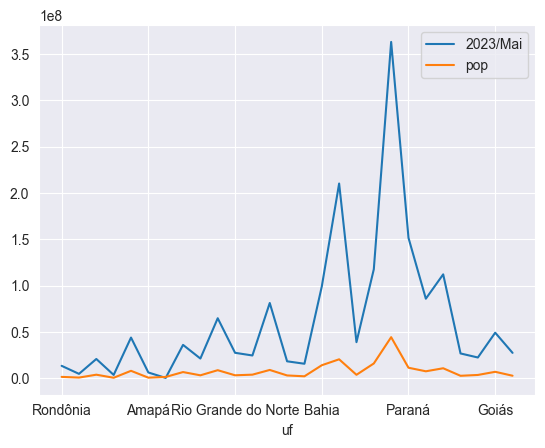

In [11]:
df_aux = df2[:, [1, -4, -1]].to_pandas().set_index('uf')
df_aux.plot();

In [12]:
#criando no Dataframe a coluna total e o gasto médio por habitante
df2 = df2.with_columns(
        pl.sum_horizontal(
            pl.col(pl.Float64).fill_null(0)
        ).alias('total')
    ).with_columns(
        (
            pl.col('total')/pl.col('pop')/186
        ).alias('total_per_capita_media')
    )

### Desafio:
- Deixar o gráfico mais arrumado com legenda adequada, títulos, eixos e ordenar do maior gasto por habitante para o menor
- Sinalizar a média geral no gráfico
- Ordenar por número de habitantes

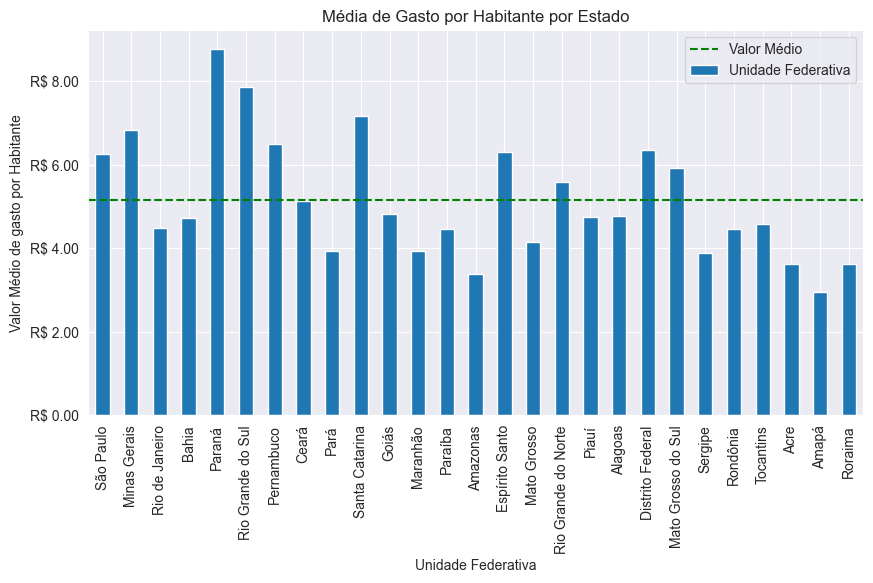

In [13]:
df_aux = df2[:, [1, -1, -3]].sort(by="pop", descending=True).to_pandas().set_index('uf')

ax = df_aux['total_per_capita_media'].plot(
    kind='bar', 
    figsize=(10, 5),
    label='Unidade Federativa')
ax.axhline(y=df_aux['total_per_capita_media'].mean(), color='green', linestyle='--', label='Valor Médio')

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('R$ {x:,.2f}'))

ax.set_xlabel('Unidade Federativa')
ax.set_ylabel('Valor Médio de gasto por Habitante')

ax.title.set_text('Média de Gasto por Habitante por Estado')
ax.legend(loc='best', bbox_to_anchor=(1,1))

plt.show()

## 2.1 Visualização com Seaborn

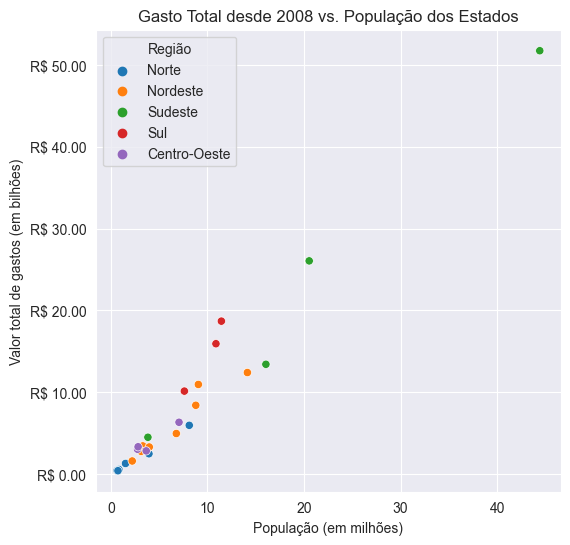

In [14]:
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(
    data = df2.select(
        pl.col('pop')/1_000_000,
        pl.col('total')/1_000_000_000,
        pl.col('regiao')
    ),
    x='pop',
    y='total',
    hue='regiao'
);

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('R$ {x:,.2f}'))

ax.set_xlabel('População (em milhões)')
ax.set_ylabel('Valor total de gastos (em bilhões)')

ax.title.set_text('Gasto Total desde 2008 vs. População dos Estados')
ax.legend(loc='best', title='Região')

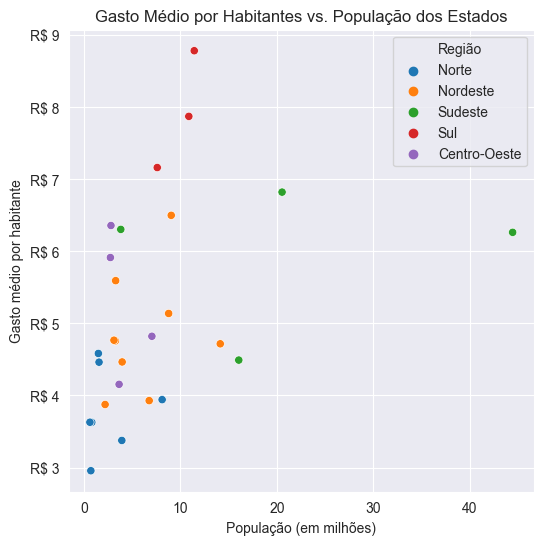

In [15]:
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(
    data = df2.select(
        pl.col('pop')/1_000_000,
        pl.col('total_per_capita_media'),
        pl.col('regiao')
    ),
    x='pop',
    y='total_per_capita_media',
    hue='regiao'
);

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('R$ {x:,.0f}'))

ax.set_xlabel('População (em milhões)')
ax.set_ylabel('Gasto médio por habitante')

ax.title.set_text('Gasto Médio por Habitantes vs. População dos Estados')
ax.legend(loc='best', title='Região');

### Desafio
- Plotar um gráfico comparando períodos diferentes de gasto

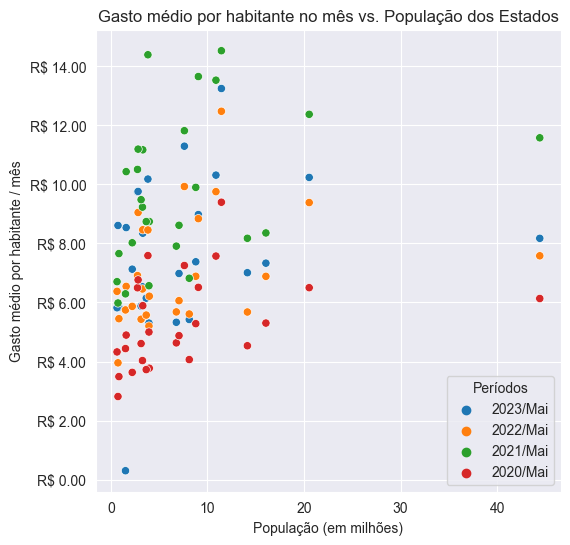

In [16]:
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(
    df2.select(
        pl.col('pop')/1_000_000,
        pl.col(['2023/Mai', '2022/Mai', '2021/Mai', '2020/Mai'])/pl.col('pop'),
    ).melt(id_vars=['pop']),
    x='pop',
    y='value',
    hue='variable'
);

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('R$ {x:,.2f}'))

ax.set_xlabel('População (em milhões)')
ax.set_ylabel('Gasto médio por habitante / mês')

ax.title.set_text('Gasto médio por habitante no mês vs. População dos Estados')
ax.legend(loc='best', title='Períodos');

## 2.2 Ticks, escalas e formatação de imagem

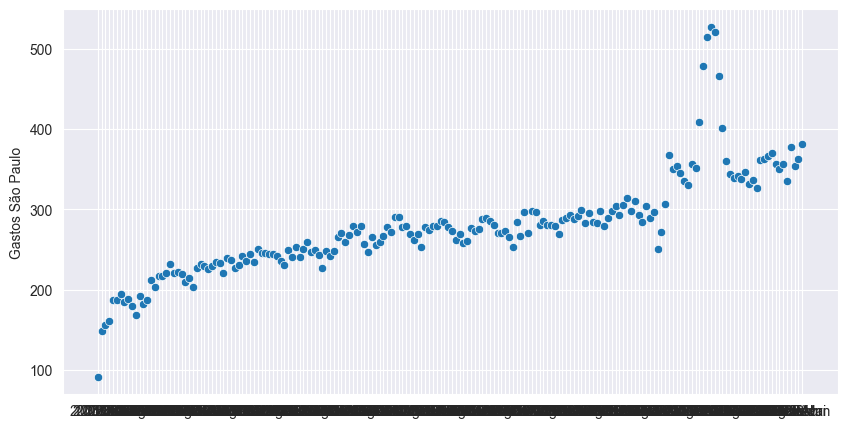

In [18]:
df_aux = (df2.filter(
        pl.col('uf') == 'São Paulo'
    )
    .select(
        pl.col('*').exclude('index', 'uf', 'pop', 'regiao', 'total', 'total_per_capita_media')
    )
)

plt.figure(figsize=(10, 5))
sns.scatterplot(
    y = df_aux.transpose(column_names=['Gastos São Paulo']).to_series()/1_000_000,
    x=df_aux.columns
);

### Desafio
- Plotar um gráfico com dois estados

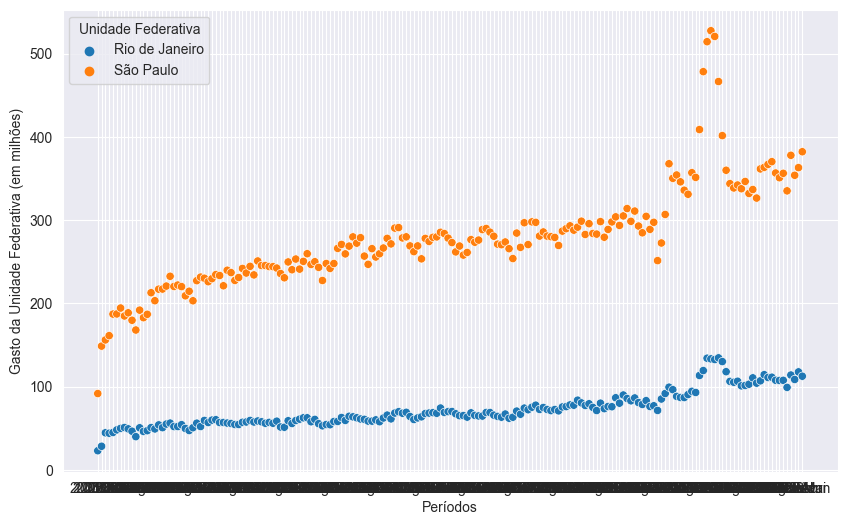

In [39]:
df_aux = (df2.filter(
        (pl.col('uf') == 'São Paulo') | (pl.col('uf') == 'Rio de Janeiro')
    )
    .select(
        pl.col('uf'),
        pl.col('*').exclude('index', 'uf', 'pop', 'regiao', 'total', 'total_per_capita_media')/1_000_000
    )
)

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data = df_aux.melt(id_vars=['uf']),
    y = 'value',
    x= 'variable',
    hue='uf'
)

ax.set_xlabel('Períodos')
ax.set_ylabel('Gasto da Unidade Federativa (em milhões)')

ax.legend(loc='best', title='Unidade Federativa');

Melhorando a visualização do gráfico

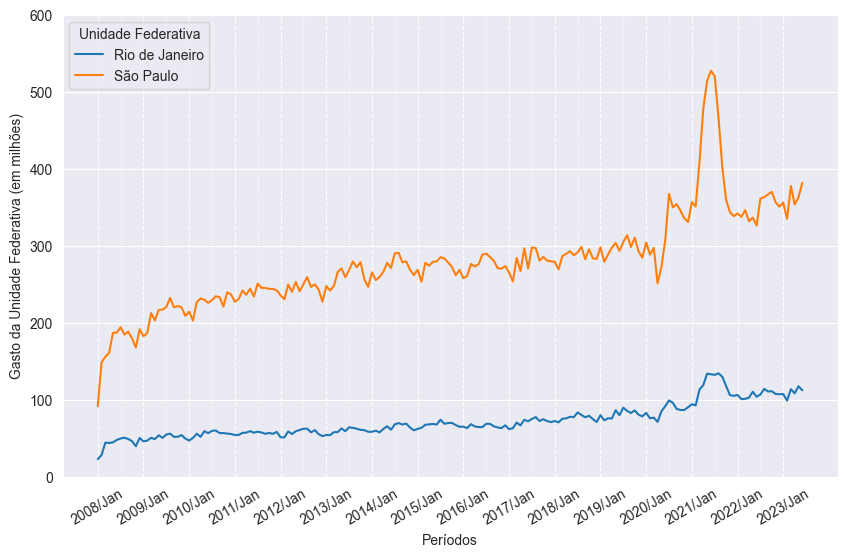

In [69]:
#criando dataframe temporário para plotar o gráfico
df_aux = (df2.filter(
        (pl.col('uf') == 'São Paulo') | (pl.col('uf') == 'Rio de Janeiro')
    )
    .select(
        pl.col('uf'),
        pl.col('*').exclude('index', 'uf', 'pop', 'regiao', 'total', 'total_per_capita_media')/1_000_000
    )
)

#plotando o gráfico de linhas
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data = df_aux.melt(id_vars=['uf']),
    y = 'value',
    x= 'variable',
    hue='uf'
)

#Definindo limite do eixo y
y_max = (
    round(
            df_aux.melt(id_vars=['uf'])['value'].max()/100+1
        )*100
    )
plt.ylim(0, y_max)

#Alterando o intervalo do eixo x, estilo do grid e rotação
ax.xaxis.set_minor_locator(ticker.IndexLocator(base=12, offset=6))
plt.grid(axis='x', linestyle=':', which='minor', alpha=0.9)
ax.xaxis.set_major_locator(ticker.IndexLocator(base=12, offset=0))
plt.grid(axis='x', linestyle='--', which='major')
plt.xticks(rotation=30)

#Alterando Labels dos eixos
ax.set_xlabel('Períodos')
ax.set_ylabel('Gasto da Unidade Federativa (em milhões)')
ax.legend(loc='best', title='Unidade Federativa');

# 3. Datetime e Melt

In [97]:
#Criando uma cópia do Dataframe nesse momento
df3 = df2.clone()

Uma forma de percorrer todos os meses do dataframe

In [98]:
col = df3.select(
    pl.col('*').exclude('index', 'uf', 'pop', 'regiao', 'total', 'total_per_capita_media')
).columns

for x in col: print(f"Valor: {x}")

Valor: 2008/Jan
Valor: 2008/Fev
Valor: 2008/Mar
Valor: 2008/Abr
Valor: 2008/Mai
Valor: 2008/Jun
Valor: 2008/Jul
Valor: 2008/Ago
Valor: 2008/Set
Valor: 2008/Out
Valor: 2008/Nov
Valor: 2008/Dez
Valor: 2009/Jan
Valor: 2009/Fev
Valor: 2009/Mar
Valor: 2009/Abr
Valor: 2009/Mai
Valor: 2009/Jun
Valor: 2009/Jul
Valor: 2009/Ago
Valor: 2009/Set
Valor: 2009/Out
Valor: 2009/Nov
Valor: 2009/Dez
Valor: 2010/Jan
Valor: 2010/Fev
Valor: 2010/Mar
Valor: 2010/Abr
Valor: 2010/Mai
Valor: 2010/Jun
Valor: 2010/Jul
Valor: 2010/Ago
Valor: 2010/Set
Valor: 2010/Out
Valor: 2010/Nov
Valor: 2010/Dez
Valor: 2011/Jan
Valor: 2011/Fev
Valor: 2011/Mar
Valor: 2011/Abr
Valor: 2011/Mai
Valor: 2011/Jun
Valor: 2011/Jul
Valor: 2011/Ago
Valor: 2011/Set
Valor: 2011/Out
Valor: 2011/Nov
Valor: 2011/Dez
Valor: 2012/Jan
Valor: 2012/Fev
Valor: 2012/Mar
Valor: 2012/Abr
Valor: 2012/Mai
Valor: 2012/Jun
Valor: 2012/Jul
Valor: 2012/Ago
Valor: 2012/Set
Valor: 2012/Out
Valor: 2012/Nov
Valor: 2012/Dez
Valor: 2013/Jan
Valor: 2013/Fev
Valor: 2

In [99]:
dict_month = {
    'Jan': 'Jan',
    'Fev': 'Feb',
    'Mar': 'Mar',
    'Abr': 'Apr',
    'Mai': 'May',
    'Jun': 'Jun',
    'Jul': 'Jul',
    'Ago': 'Aug',
    'Set': 'Sep',
    'Out': 'Oct',
    'Nov': 'Nov',
    'Dez': 'Dec'
}

df3 = df3.select(
    pl.col('*').exclude('index', 'pop', 'regiao', 'total', 'total_per_capita_media')
).melt(
    id_vars=['uf'],
    variable_name='periodo',
    value_name='valor'
).select(
    pl.col('uf'),
    #converter o mês para o formato datetime
    pl.col('periodo').map_elements(
        lambda x: dict_month[x.split('/')[1]] + '/' + x.split('/')[0]
    ).str.to_date('%b/%Y'),
    pl.col('valor')
)


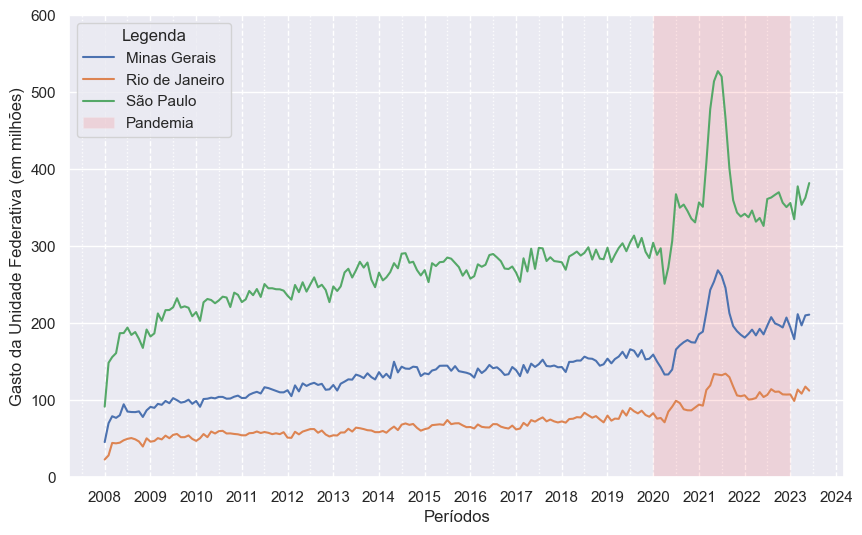

In [160]:
#criando dataframe temporário para plotar o gráfico
import datetime


df_aux = (df3.filter(
        (pl.col('uf') == 'São Paulo') | 
        (pl.col('uf') == 'Rio de Janeiro') |
        (pl.col('uf') == 'Minas Gerais')
    ).select(
        pl.col(['uf', 'periodo']),
        pl.col('valor')/1_000_100
    )
)

#plotando o gráfico de linhas
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data = df_aux,
    y = 'valor',
    x= 'periodo',
    hue='uf'
)
plt.axvspan(
    xmin=datetime.date(2020,1,1), 
    xmax=datetime.date(2023,1,1), 
    facecolor='red', 
    alpha=0.1, 
    label='Pandemia'
    )

#Definindo limite do eixo y
y_max = (
    round(
            df_aux['valor'].max()/100+1
        )*100
    )
plt.ylim(0, y_max)

#Alterando o estilo do grid
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonth=7))
plt.grid(axis='x', linestyle=':', which='minor', alpha=0.9)
ax.xaxis.set_major_locator(dates.YearLocator())
plt.grid(axis='x', linestyle='--', which='major')



#Alterando Labels dos eixos
ax.set_xlabel('Períodos')
ax.set_ylabel('Gasto da Unidade Federativa (em milhões)')
ax.legend(loc='best', title='Legenda');

### Desafio:
- Criar uma tabela onde cada linha representa o período e os gastos de cada estado em colunas a partir do dataframe com Melt.

In [113]:
df3.pivot(columns='uf', values='valor', index='periodo')

periodo,Rondônia,Acre,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,Ceará,Rio Grande do Norte,Paraíba,Pernambuco,Alagoas,Sergipe,Bahia,Minas Gerais,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2008-01-01,1388528.39,902416,4735529.42,657889.53,18864744.11,1120973.34,3441592.69,10723506.39,7985142.43,15539821.9,5947814.08,10723002.45,14393949.89,6243726.32,2780750.11,21211522.47,45671659.76,5456723.98,23025258.52,91678473.48,38266347.46,16504913.45,30931325.46,5377392.11,4795299.01,15310637.29,4745919.19
2008-02-01,2931283.42,1497206.26,7118990.57,777939.31,19553758.2,1268740.33,4985688.85,13559679.41,10079928.25,25735101.55,9509755.83,11386274.47,24181400.95,8376622.16,3676483.16,28189304.95,70194037.1,9102212.86,28394310.93,148677526.82,55384670.52,25651429.11,57363420.01,7002472.61,8684882.23,22258668.68,7632480.67
2008-03-01,1541682.52,1794028.48,8196635.49,718688.03,21937342.7,974651.24,6205612.6,13985142.36,10298372.45,28724625.75,10352238.59,12053643.87,29991302.71,8408336.22,5051473.61,34181483.52,79231336.95,10249595.97,44567062.94,156087269.23,53801318.85,26743524.89,51547794.07,8423933.19,7886243.14,21442515.75,9647203.26
2008-04-01,1525314.96,1730469.42,8259378.42,839994.39,20842829.69,1141137.32,4984482.09,14809416.46,10775976.33,30676457.06,10855108.5,12653528.76,34806197.97,9090794.82,5046063.36,39026934.13,77136537.58,11253833.56,44054604.82,161227125.43,52460306.69,27181488.26,56673338.49,8797487.68,8794109.79,20921212.45,11098732.99
2008-05-01,1645953.84,1819443.92,7831399.9,862347.96,23249952.88,866346.18,5511002.46,14505727.38,10398360.88,30604453.47,11160168.19,12215107.11,32147987.35,9338771.45,4741151.56,42949566.82,80554440.63,10198619.17,44911021.15,187119397.64,54419620.71,26845308.18,48397733.07,9770421.8,9231645.4,21615970.67,12891719.72
2008-06-01,1406150.68,1828496,8477273.62,832440.66,23240687.56,1440978.95,4927934.22,14908091.32,10528253.88,31272395.18,10475071.38,12256928.49,32239094.89,10068210.08,5401259.63,47025972.04,94758522.83,13364258.29,48056212.24,187291126.07,57811688.48,29909762.04,52413429.62,10905392.18,10221763.77,18270043.87,12850125.67
2008-07-01,3065279.01,2511754.59,9368858.72,996693.09,24002223.56,1426659.48,5445602.28,15784899.4,11040107.92,30925391.36,11386349.96,12755413.77,32685640.76,9887061.61,5521904.44,47481695.17,85360064.11,13035374.08,49872379.35,194398399.48,58094241.83,30789135.84,56636376.98,10249299.82,9163314.28,20540517.13,12565646.74
2008-08-01,3231494.61,2089107.14,9352532.7,894271.18,23341218.03,1475551.38,5413710.38,15195312.89,10549176.4,27851438.72,10640817.47,12872578.37,35457038.66,9373432,5238398.5,46931248.28,84722528.1,12588595.77,50912706.6,184854516.35,56982774.9,31250854.33,56113054.7,9671553.45,9243148.81,20650730.67,13710857.89
2008-09-01,3117178.63,2275708.53,9363099.35,910424.17,25172261.32,1651341.43,5596669.5,14951277.75,10899198.97,30362719.9,11336030.28,12558296.11,33668261.46,9563580.5,5187912.19,44883379.31,84601757.95,12727433.3,49270352.76,188636359.55,57549082.26,30019676.93,55356224.3,10218511.05,9052354.89,20868443.56,13165106.2


## 3.1 Manipulando Datas

In [129]:
#Criando uma cópia do Dataframe nesse momento
df4 = df3.clone()

In [136]:
#Craindo colunas para ano e para mes
df4 = df4.with_columns(
    pl.col('periodo').dt.year().alias('ano'),
    pl.col('periodo').dt.month().alias('mes')
)

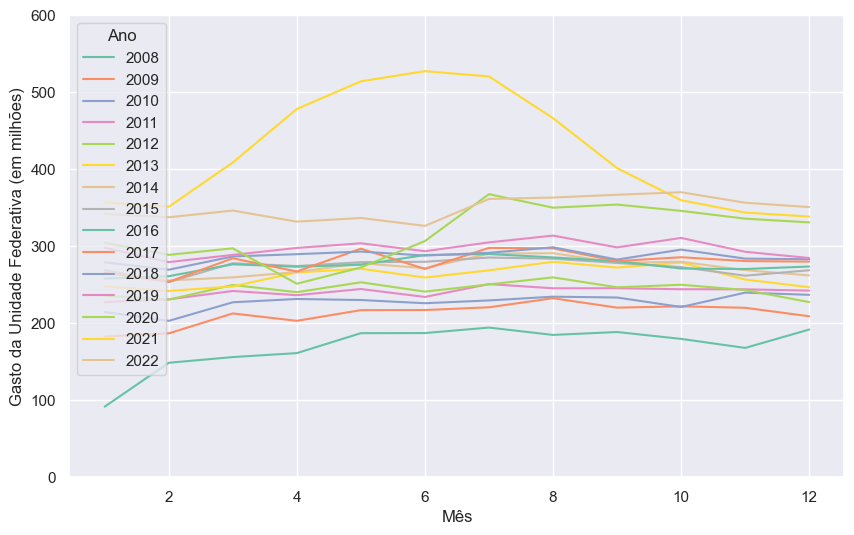

In [149]:
#criando dataframe temporário para plotar o gráfico
df_aux = (df4.filter(
        (pl.col('uf') == 'São Paulo') &
        (pl.col('ano') < 2023)
    ).select(
        pl.col(['uf', 'mes', 'ano']),
        pl.col('valor')/1_000_100
    )
)

#plotando o gráfico de linhas
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data = df_aux,
    y = 'valor',
    x= 'mes',
    hue='ano',
    palette='Set2'
)

#Definindo limite do eixo y
y_max = (
    round(
            df_aux['valor'].max()/100+1
        )*100
    )
plt.ylim(0, y_max)

#Alterando Labels dos eixos
ax.set_xlabel('Mês')
ax.set_ylabel('Gasto da Unidade Federativa (em milhões)')
ax.legend(loc='best', title='Ano');

### Desafio
- Escolher um ano e plotar o mesmo ano para dois estados de regiões diferentes no mesmo gráfico
- Ajustar cores, labels, espaçamentos dos ticks
- Mostrar o nome dos meses no eixo X

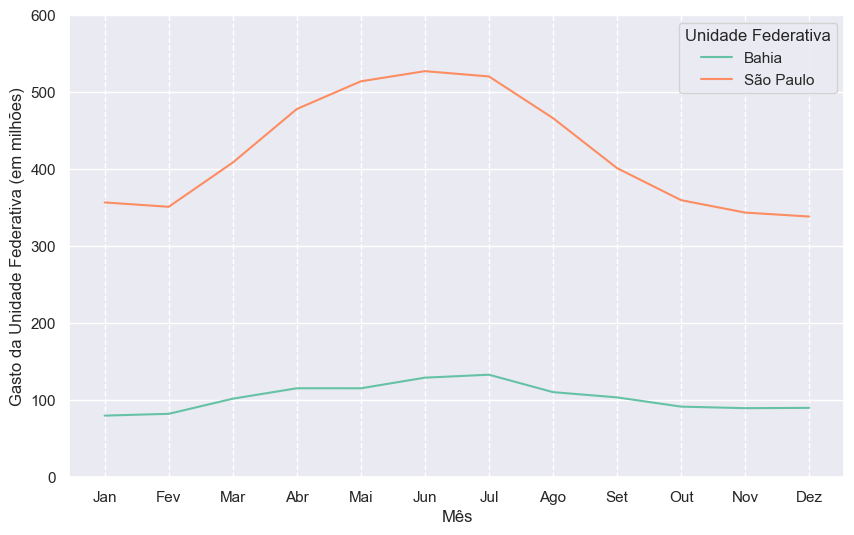

In [170]:
#criando dataframe temporário para plotar o gráfico
df_aux = (df4.filter(
        ((pl.col('uf') == 'São Paulo') | (pl.col('uf') == 'Bahia')) &
        (pl.col('ano') == 2021)
    ).select(
        pl.col(['uf', 'mes', 'ano']),
        pl.col('valor')/1_000_100
    )
)

#plotando o gráfico de linhas
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data = df_aux,
    y = 'valor',
    x= 'mes',
    hue='uf',
    palette='Set2'
)

#Ajustando e renomeando ticks eixo X
labels_mes = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
ax.xaxis.set_major_locator(ticker.FixedLocator(range(1, 13)))
ax.set_xticklabels(labels_mes)
plt.grid(axis='x', linestyle='--', which='major')

#Definindo limite do eixo y
y_max = (
    round(
            df_aux['valor'].max()/100+1
        )*100
    )
plt.ylim(0, y_max)

#Alterando Labels dos eixos
ax.set_xlabel('Mês')
ax.set_ylabel('Gasto da Unidade Federativa (em milhões)')
ax.legend(loc='best', title='Unidade Federativa');

In [174]:
dias_mes = {
    1: 31,
    2: 28,
    3: 31,
    4: 30,
    5: 31,
    6: 30,
    7: 31,
    8: 31,
    9: 30,
    10: 31,
    11: 30,
    12: 31
}

df4 = df4.with_columns(
    (pl.col('valor') / (pl.col('mes').map_dict(dias_mes))).alias('valor_dia')
)

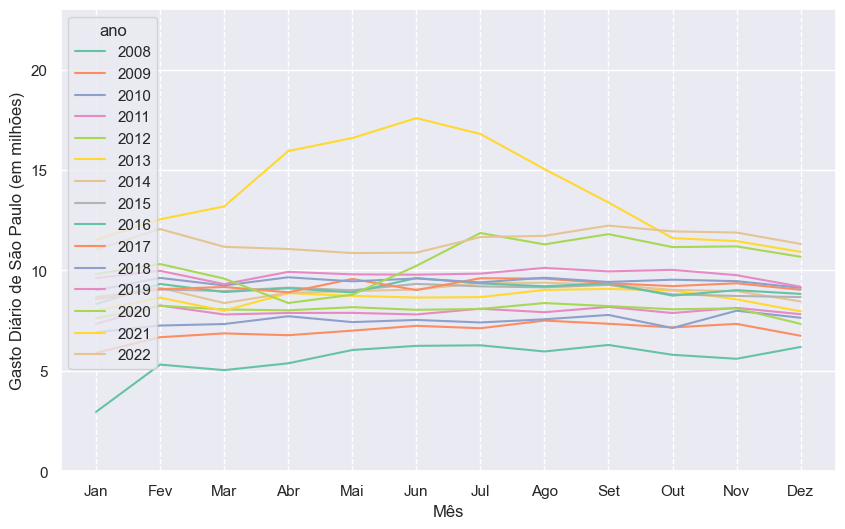

In [183]:
#criando dataframe temporário para plotar o gráfico
df_aux = (df4.filter(
        (pl.col('uf') == 'São Paulo') &
        (pl.col('ano') < 2023)
    ).select(
        pl.col(['uf', 'mes', 'ano']),
        pl.col('valor_dia')/1_000_100
    )
)

#plotando o gráfico de linhas
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data = df_aux,
    y = 'valor_dia',
    x= 'mes',
    hue='ano',
    palette='Set2'
)

#Ajustando e renomeando ticks eixo X
labels_mes = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
ax.xaxis.set_major_locator(ticker.FixedLocator(range(1, 13)))
ax.set_xticklabels(labels_mes)
plt.grid(axis='x', linestyle='--', which='major')

#Definindo limite do eixo y
y_max = (
    round(
            df_aux['valor_dia'].max()
        )+5
    )
plt.ylim(0, y_max)

#Alterando Labels dos eixos
ax.set_xlabel('Mês')
ax.set_ylabel('Gasto Diário de São Paulo (em milhões)');

### Desafio:
- Escolha dois estados e calcule o gasto per capita por mês para cada estado em um determiando ano

In [192]:
dict_month = {
    'Jan': 'Jan',
    'Fev': 'Feb',
    'Mar': 'Mar',
    'Abr': 'Apr',
    'Mai': 'May',
    'Jun': 'Jun',
    'Jul': 'Jul',
    'Ago': 'Aug',
    'Set': 'Sep',
    'Out': 'Oct',
    'Nov': 'Nov',
    'Dez': 'Dec'
}

df_aux = df2.select(
    pl.col(['uf', 'pop']),
    pl.col('*').exclude('index', 'uf', 'pop', 'regiao', 'total', 'total_per_capita_media')
).melt(
    id_vars=['uf', 'pop'],
    variable_name='periodo',
    value_name='valor'
).select(
    pl.col(['uf', 'pop']),
    #converter o mês para o formato datetime
    pl.col('periodo').map_elements(
        lambda x: dict_month[x.split('/')[1]] + '/' + x.split('/')[0]
    ).str.to_date('%b/%Y'),
    (pl.col('valor')/pl.col('pop')).alias('valor_per_capita'),
).with_columns(
    pl.col('periodo').dt.year().alias('ano'),
    pl.col('periodo').dt.month().alias('mes')
)

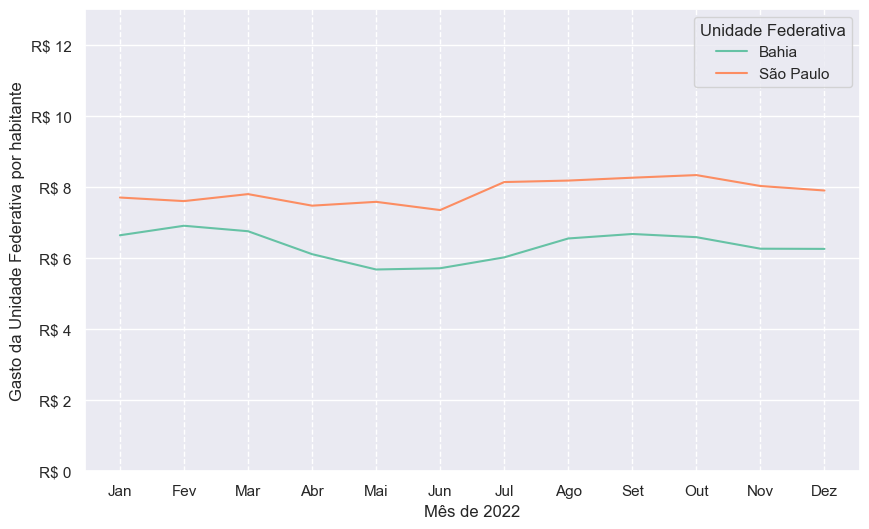

In [200]:
#criando dataframe temporário para plotar o gráfico
df_aux = (df_aux.filter(
        ((pl.col('uf') == 'São Paulo') | (pl.col('uf') == 'Bahia')) &
        (pl.col('ano') == 2022)
    ).select(
        pl.col(['uf', 'mes', 'ano']),
        pl.col('valor_per_capita')
    )
)

#plotando o gráfico de linhas
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data = df_aux,
    y = 'valor_per_capita',
    x= 'mes',
    hue='uf',
    palette='Set2'
)

#Ajustando e renomeando ticks eixo X
labels_mes = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
ax.xaxis.set_major_locator(ticker.FixedLocator(range(1, 13)))
ax.set_xticklabels(labels_mes)
plt.grid(axis='x', linestyle='--', which='major')


#Definindo limite do eixo y
y_max = (
    round(
            df_aux['valor_per_capita'].max()
        )+5
    )
plt.ylim(0, y_max)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('R$ {x:,.0f}'))

#Alterando Labels dos eixos
ax.set_xlabel('Mês de 2022')
ax.set_ylabel('Gasto da Unidade Federativa por habitante')
ax.legend(loc='best', title='Unidade Federativa');